In [1]:
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
elapsed_time_group = re.compile(r": (\d.*)s")
etot_group = re.compile(r"Etot: (.*)")

In [3]:
sns.set_style('whitegrid')

In [4]:
def read_sim_time_from_report(fname):
    with open(fname) as f:
        payload = f.read()
    seq_ap, seq_ap_avx, omp_ap = payload.split("\n\n")
    el_time_seq_ap = np.array([float(re.search(elapsed_time_group, l).group(1)) for l in seq_ap.splitlines() if re.search(elapsed_time_group, l)])
    el_time_seq_ap_avx = np.array([float(re.search(elapsed_time_group, l).group(1)) for l in seq_ap_avx.splitlines() if re.search(elapsed_time_group, l)])
    el_time_omp_ap = np.array([float(re.search(elapsed_time_group, l).group(1)) for l in omp_ap.splitlines() if re.search(elapsed_time_group, l)])
    return el_time_seq_ap, el_time_seq_ap_avx, el_time_omp_ap

In [5]:
def read_etot_from_report(fname):
    with open(fname) as f:
        payload = f.read()
    seq_ap, seq_ap_avx, omp_ap = payload.split("\n\n")
    etot_seq_ap = np.array([float(re.search(etot_group, l).group(1)) for l in seq_ap.splitlines() if re.search(etot_group, l)])
    etot_seq_ap_avx = np.array([float(re.search(etot_group, l).group(1)) for l in seq_ap_avx.splitlines() if re.search(etot_group, l)])
    etot_omp_ap = np.array([float(re.search(etot_group, l).group(1)) for l in omp_ap.splitlines() if re.search(etot_group, l)])
    return etot_seq_ap, etot_seq_ap_avx, etot_omp_ap

In [6]:
el_time_seq_ap, el_time_seq_ap_avx, el_time_omp_ap = read_sim_time_from_report("./report_sequential1.txt")
etot_seq_ap_sp, etot_seq_ap_avx_sp, etot_omp_ap_sp = read_etot_from_report("./simulation_sequential_single_prec.txt")
etot_seq_ap_dp, etot_seq_ap_avx_dp, etot_omp_ap_dp = read_etot_from_report("./simulation_sequential_double_prec.txt")

In [7]:
for i in range(2, 6):
    y1, y2, y3 = read_sim_time_from_report(f"./report_sequential{i}.txt")
    el_time_seq_ap = np.vstack((el_time_seq_ap, y1))
    el_time_seq_ap_avx = np.vstack((el_time_seq_ap_avx, y2))
    el_time_omp_ap = np.vstack((el_time_omp_ap, y3))

In [8]:
mu_el_time_seq_ap = np.mean(el_time_seq_ap, axis=0)
mu_el_time_seq_ap_avx = np.mean(el_time_seq_ap_avx, axis=0)
mu_el_time_omp_ap = np.mean(el_time_omp_ap, axis=0)

std_el_time_seq_ap = np.std(el_time_seq_ap, axis=0)
std_el_time_seq_ap_avx = np.std(el_time_seq_ap_avx, axis=0)
std_el_time_omp_ap = np.std(el_time_omp_ap, axis=0)

In [9]:
x = np.array([2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192])
n_threads = np.array([2*i if i != 0 else 1 for i in range(17)])

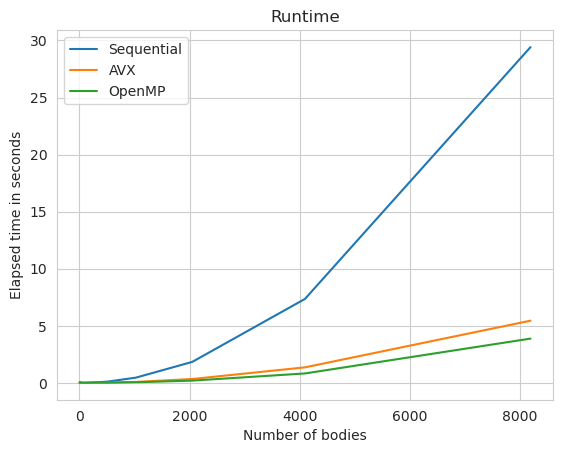

In [10]:
ax = sns.lineplot(x=x, y=mu_el_time_seq_ap, label="Sequential")
ax.fill_between(x, mu_el_time_seq_ap - std_el_time_seq_ap, mu_el_time_seq_ap + std_el_time_seq_ap, alpha=.3)
sns.lineplot(x=x, y=mu_el_time_seq_ap_avx, ax=ax, label="AVX")
ax.fill_between(x, mu_el_time_seq_ap_avx - std_el_time_seq_ap_avx, mu_el_time_seq_ap_avx + std_el_time_seq_ap_avx, alpha=.3)
sns.lineplot(x=x, y=mu_el_time_omp_ap[16::33], ax=ax, label="OpenMP")
ax.fill_between(x, mu_el_time_omp_ap[16::33] - std_el_time_omp_ap[16::33], mu_el_time_omp_ap[16::33] + std_el_time_omp_ap[16::33], alpha=.3)
ax.set_xlabel("Number of bodies") 
ax.set_ylabel("Elapsed time in seconds")
ax.set_title("Runtime")
ax.legend();

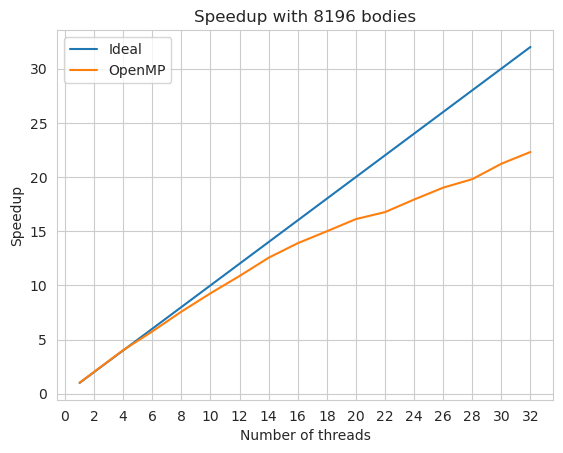

In [11]:
ax = sns.lineplot(x=n_threads, y=n_threads, label="Ideal")
sns.lineplot(x=n_threads, y=mu_el_time_seq_ap[-1]/(mu_el_time_omp_ap[-34:-17]), ax=ax, label="OpenMP")
ax.set_xlabel("Number of threads") 
ax.set_ylabel("Speedup")
ax.set_xticks(list(range(0, n_threads[-1]+1, 2)))
ax.set_title("Speedup with 8196 bodies")
ax.legend();

In [12]:
#ax = sns.lineplot(x=x[2:], y=x[2:], label="Ideal")
#sns.lineplot(x=x[2:], y=(mu_el_time_seq_ap/mu_el_time_seq_ap_avx)[2:], ax=ax, label="AVX")
#sns.lineplot(x=x[2:], y=(mu_el_time_seq_ap/mu_el_time_omp_ap[5::12])[2:], ax=ax, label="OpenMP")
#ax.legend()
#ax.set_xscale("log")
#ax.set_yscale("log")
#ax.set_xlabel("Number of bodies")
#ax.set_ylabel("Speedup");

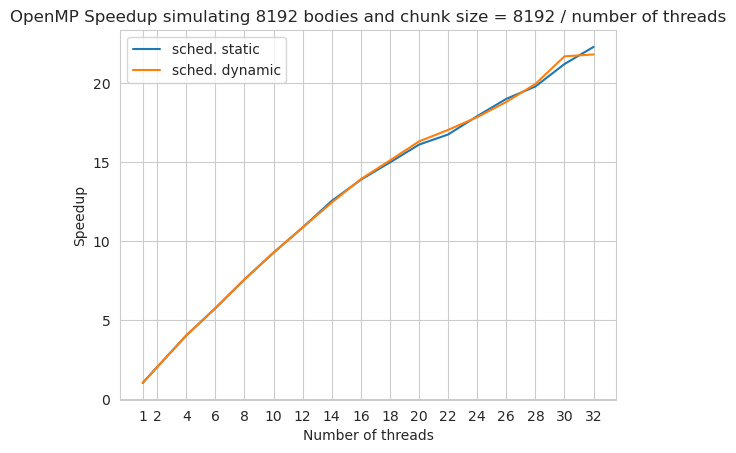

In [13]:
ax = sns.lineplot(x=n_threads, y=mu_el_time_seq_ap[-1]/mu_el_time_omp_ap[-34:-17], label="sched. static")
sns.lineplot(x=n_threads, y=mu_el_time_seq_ap[-1]/mu_el_time_omp_ap[-17:], ax=ax, label="sched. dynamic")
ax.set_xlabel("Number of threads") 
ax.set_xticks(n_threads)
ax.set_ylabel("Speedup")
ax.legend()
ax.set_title("OpenMP Speedup simulating 8192 bodies and chunk size = 8192 / number of threads");

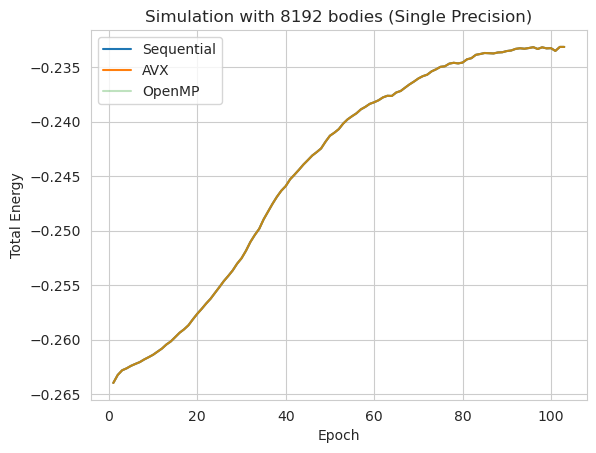

In [14]:
ax = sns.lineplot(x=range(1, etot_seq_ap_sp.size+1), y=etot_seq_ap_sp, label="Sequential")
ax = sns.lineplot(x=range(1, etot_seq_ap_avx_sp.size+1), y=etot_seq_ap_avx_sp, label="AVX")
ax = sns.lineplot(x=range(1, etot_omp_ap_sp.size+1), y=etot_omp_ap_sp, label="OpenMP", alpha=0.3)
ax.set_xlabel("Epoch") 
ax.set_ylabel("Total Energy")
ax.set_title("Simulation with 8192 bodies (Single Precision)")
ax.legend();

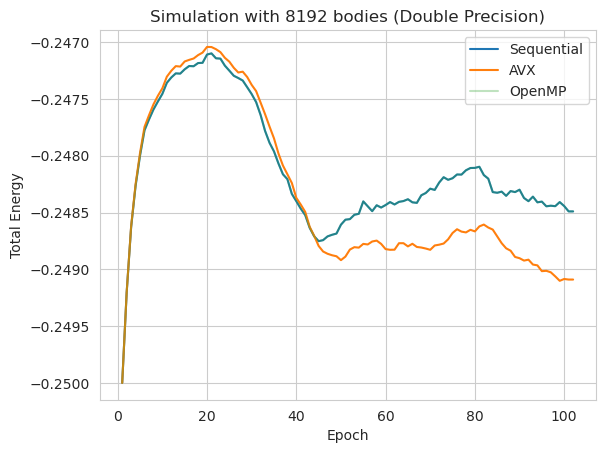

In [15]:
ax = sns.lineplot(x=range(1, etot_seq_ap_dp.size+1), y=etot_seq_ap_dp, label="Sequential")
ax = sns.lineplot(x=range(1, etot_seq_ap_avx_dp.size+1), y=etot_seq_ap_avx_dp, label="AVX")
ax = sns.lineplot(x=range(1, etot_omp_ap_dp.size+1), y=etot_omp_ap_dp, label="OpenMP", alpha=0.3)
ax.set_xlabel("Epoch") 
ax.set_ylabel("Total Energy")
ax.set_title("Simulation with 8192 bodies (Double Precision)")
ax.legend();

In [16]:
def read_sim_time_from_cpu_report(fname):
    with open(fname) as f:
        payload = f.read()
    seq_ap, omp_ap = payload.split("\n\n")
    el_time_seq_ap = np.array([float(re.search(elapsed_time_group, l).group(1)) for l in seq_ap.splitlines() if re.search(elapsed_time_group, l)])
    el_time_omp_ap = np.array([float(re.search(elapsed_time_group, l).group(1)) for l in omp_ap.splitlines() if re.search(elapsed_time_group, l)])
    return el_time_seq_ap, el_time_omp_ap

In [17]:
def read_sim_time_from_cuda_report(fname):
    with open(fname) as f:
        payload = f.read()
    el_time_cuda_ap = np.array([float(re.search(elapsed_time_group, l).group(1)) for l in payload.splitlines() if re.search(elapsed_time_group, l)])
    return el_time_cuda_ap

In [18]:
n_threads = [1, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 78, 80]

In [19]:
x = np.array([2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384])

In [20]:
el_time_cuda_ap = read_sim_time_from_cuda_report("./epito/cuda_nbody_report_run1.txt")
el_time_seq_ap, el_time_omp_ap = read_sim_time_from_cpu_report("./epito/seq_nbody_report_run1.txt")

In [21]:
for i in range(2, 6):
    y1, y2 = read_sim_time_from_cpu_report(f"./epito/seq_nbody_report_run{i}.txt")
    el_time_seq_ap = np.vstack((el_time_seq_ap, y1))
    el_time_omp_ap = np.vstack((el_time_omp_ap, y2))
    y1 = read_sim_time_from_cuda_report(f"./epito/cuda_nbody_report_run{i}.txt")
    el_time_cuda_ap = np.vstack((el_time_cuda_ap, y1))

In [22]:
mu_el_time_seq_ap = np.mean(el_time_seq_ap, axis=0)
mu_el_time_omp_ap = np.mean(el_time_omp_ap, axis=0)
mu_el_time_cuda_ap = np.std(el_time_cuda_ap, axis=0)

std_el_time_seq_ap = np.std(el_time_seq_ap, axis=0)
std_el_time_omp_ap = np.std(el_time_omp_ap, axis=0)
std_el_time_cuda_ap = np.std(el_time_cuda_ap, axis=0)

In [23]:
best_el_time_omp = [min(mu_el_time_omp_ap[82*i:82*(i+1)]) for i in range(len(x))]

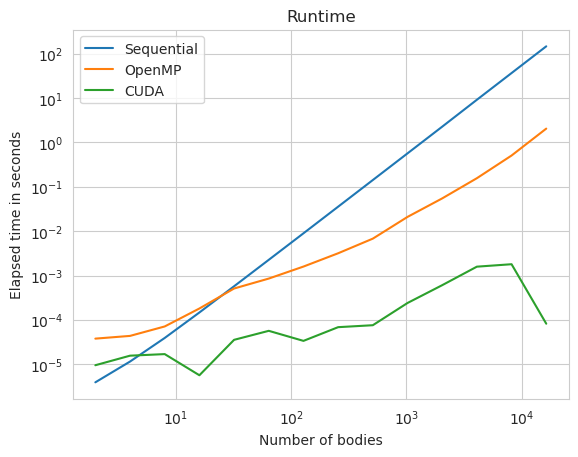

In [24]:
ax = sns.lineplot(x=x, y=mu_el_time_seq_ap, label="Sequential")
sns.lineplot(x=x, y=best_el_time_omp, ax=ax, label="OpenMP")
sns.lineplot(x=x, y=mu_el_time_cuda_ap, ax=ax, label="CUDA")
ax.set_xlabel("Number of bodies")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylabel("Elapsed time in seconds")
ax.set_title("Runtime")
ax.legend();

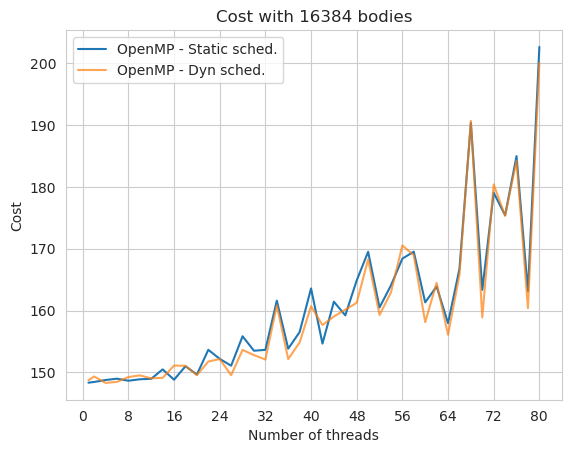

In [39]:
ax = sns.lineplot(x=n_threads, y=[p * t_p for p, t_p in zip(n_threads, mu_el_time_omp_ap[-82:-41])], label="OpenMP - Static sched.")
sns.lineplot(x=n_threads, y=[p * t_p for p, t_p in zip(n_threads, mu_el_time_omp_ap[-41:])], ax=ax, label="OpenMP - Dyn sched.", alpha=0.7)
# ax.fill_between(n_threads, mu_el_time_omp_ap[-82:-41] - std_el_time_omp_ap[-82:-41], mu_el_time_omp_ap[-82:-41] + std_el_time_omp_ap[-82:-41], alpha=.5)
ax.set_xlabel("Number of threads") 
ax.set_ylabel("Cost")
ax.set_xticks(list(range(0, n_threads[-1]+1, 8)))
ax.set_title("Cost with 16384 bodies")
ax.legend();

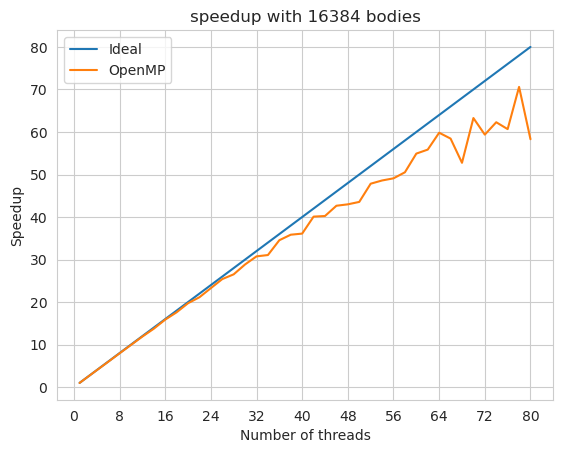

In [25]:
ax = sns.lineplot(x=n_threads, y=n_threads, label="Ideal")
sns.lineplot(x=n_threads, y=mu_el_time_seq_ap[-1]/(mu_el_time_omp_ap[-82:-41]), ax=ax, label="OpenMP")
# ax.fill_between(n_threads, mu_el_time_omp_ap[-82:-41] - std_el_time_omp_ap[-82:-41], mu_el_time_omp_ap[-82:-41] + std_el_time_omp_ap[-82:-41], alpha=.5)
ax.set_xlabel("Number of threads") 
ax.set_ylabel("Speedup")
ax.set_xticks(list(range(0, n_threads[-1]+1, 8)))
ax.set_title("Speedup with 16384 bodies")
ax.legend();

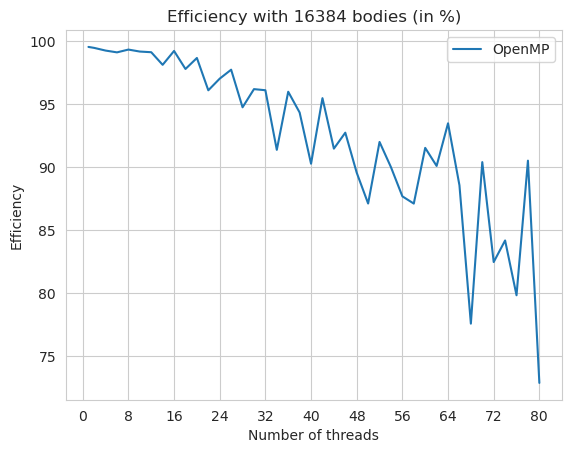

In [34]:
ax = sns.lineplot(x=n_threads, y=mu_el_time_seq_ap[-1]/(mu_el_time_omp_ap[-82:-41])/n_threads * 100, label="OpenMP")
# ax.fill_between(n_threads, mu_el_time_omp_ap[-82:-41] - std_el_time_omp_ap[-82:-41], mu_el_time_omp_ap[-82:-41] + std_el_time_omp_ap[-82:-41], alpha=.5)
ax.set_xlabel("Number of threads") 
ax.set_ylabel("Efficiency")
ax.set_xticks(list(range(0, n_threads[-1]+1, 8)))
ax.set_title("Efficiency with 16384 bodies (in %)")
ax.legend();